# Image classification

Today we are going to classify characters from The Simpsons as part of the simple Kaggle competition.

![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

import albumentations as A
import cv2
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
!nvidia-smi

Mon Aug  3 21:53:02 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 105...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   51C    P8    N/A /  N/A |     43MiB /  4042MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [4]:
import pickle

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

## Dataloader

In [5]:
# different dataset modes
DATA_MODES = ['train', 'val', 'test']
# set rescale size to be 224x224 px
RESCALE_SIZE = 224
DEVICE = torch.device("cuda")

In [6]:
from __future__ import print_function, division
import os
from skimage import io, transform
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Let's create a dataloader that will help us to load our images from folders and make desired transformations.

In [7]:
class SimpsonsDataset(Dataset):
    def __init__(self, files, mode):
        super().__init__()
        # list of files to load
        self.files = sorted(files)
        # dataset mode
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # transform images to tensors and normalize
        # add couple of augmentations if we are in the 'train' mode
        if self.mode == 'train':
            transform = transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.RandomRotation(degrees=30),
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(hue=.1, saturation=.1),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        else:
            transform = transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        x = self.load_sample(self.files[index])
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [8]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [9]:
TRAIN_DIR = Path('journey-springfield/train/simpsons_dataset')
TEST_DIR = Path('journey-springfield/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

Split files from TRAIN_DIR into train and validation parts

In [10]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [11]:
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')

## Balancing classes 

For image classification problem it is important to have balanced class distributions. Therefore, let's check how many objects of each class do we have in our dataset.

In [12]:
class_instances = {}
trainpath = 'journey-springfield/train/simpsons_dataset/'
for folder in os.listdir(trainpath):
    num = len([name for name in os.listdir(trainpath + folder)])
    class_instances[folder] = num

<BarContainer object of 42 artists>

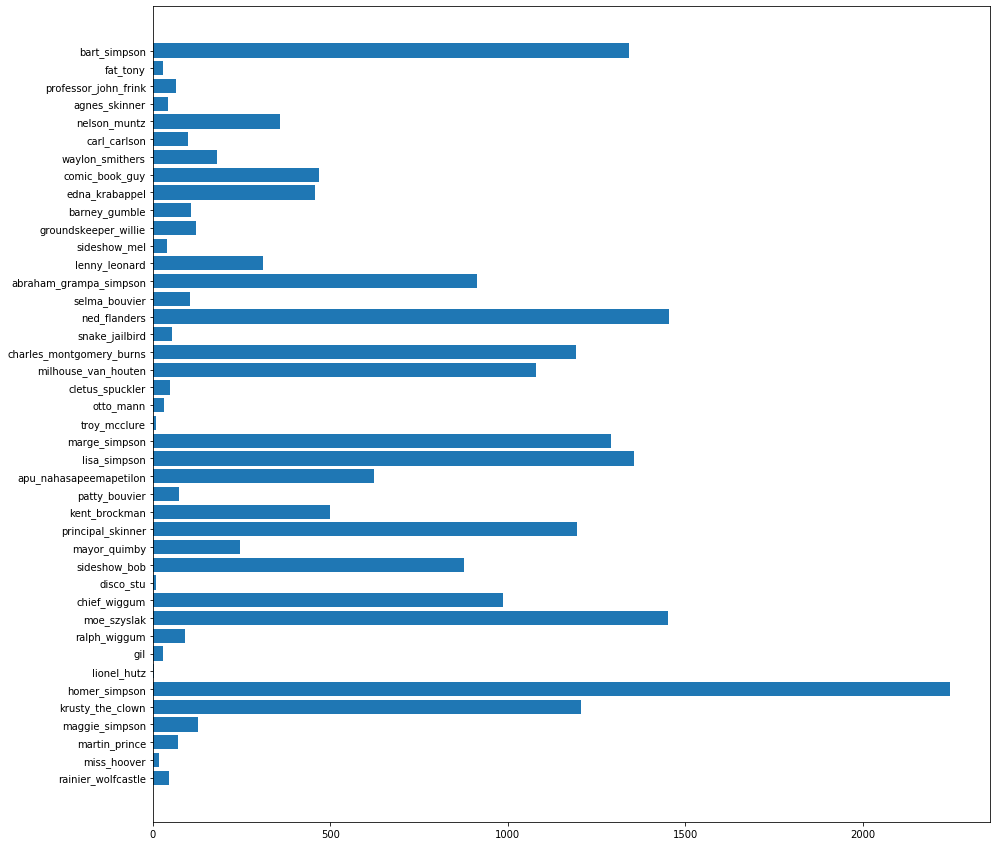

In [13]:
labels, values = zip(*class_instances.items())
plt.figure(figsize=(15,15))
plt.barh(labels, values)

As we can see from the plot above, our dataset is not balanced and some of the classes are very underrepresented, which could lead to low accuracy of our model's predictions for these classes.
Let's try to fix it.

In [18]:
def create_dct_path_labels(train_files, train_labels):
    dct_simpsons = {}
    for label_i in np.unique(train_labels).tolist():
        dct_simpsons[label_i] = []

    for path_i, label_i in zip(train_files, train_labels):
        dct_simpsons[label_i].append(path_i)

    return dct_simpsons

dct_path_train = create_dct_path_labels(train_files, train_dataset.labels)

# Increase the number of objects in a class up to 300 if it has less than 300 objects.
for person in dct_path_train:
    if len(dct_path_train[person]) < 300:
        dct_path_train[person] = dct_path_train[person] * (300 // len(dct_path_train[person]))
        dct_path_train[person].extend(dct_path_train[person][:300 - len(dct_path_train[person])])
        
for person in dct_path_train:
    print(f"{person}\t{len(dct_path_train[person])}")
new_train_files = []

for person in dct_path_train:
    new_train_files.extend(dct_path_train[person])

val_dataset = SimpsonsDataset(val_files, mode='val')
new_train_dataset = SimpsonsDataset(new_train_files, mode='train')

abraham_grampa_simpson	685
agnes_skinner	300
apu_nahasapeemapetilon	467
barney_gumble	300
bart_simpson	1006
carl_carlson	300
charles_montgomery_burns	895
chief_wiggum	739
cletus_spuckler	300
comic_book_guy	352
disco_stu	300
edna_krabappel	343
fat_tony	300
gil	300
groundskeeper_willie	300
homer_simpson	1684
kent_brockman	373
krusty_the_clown	904
lenny_leonard	300
lionel_hutz	300
lisa_simpson	1015
maggie_simpson	300
marge_simpson	968
martin_prince	300
mayor_quimby	300
milhouse_van_houten	809
miss_hoover	300
moe_szyslak	1089
ned_flanders	1090
nelson_muntz	300
otto_mann	300
patty_bouvier	300
principal_skinner	895
professor_john_frink	300
rainier_wolfcastle	300
ralph_wiggum	300
selma_bouvier	300
sideshow_bob	658
sideshow_mel	300
snake_jailbird	300
troy_mcclure	300
waylon_smithers	300


Plot some of the images from the val part of the dataset.

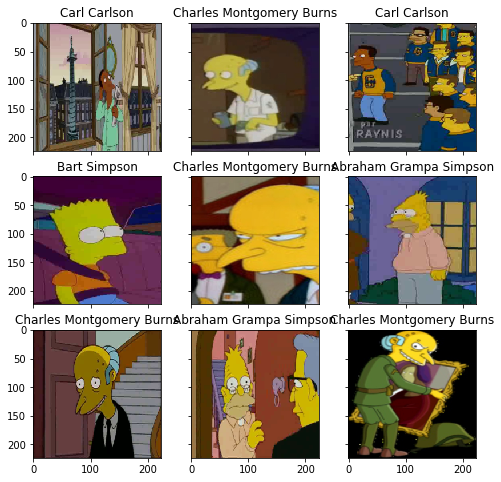

In [22]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Plot some of the images from the train part of the dataset. We should see some augmented images.

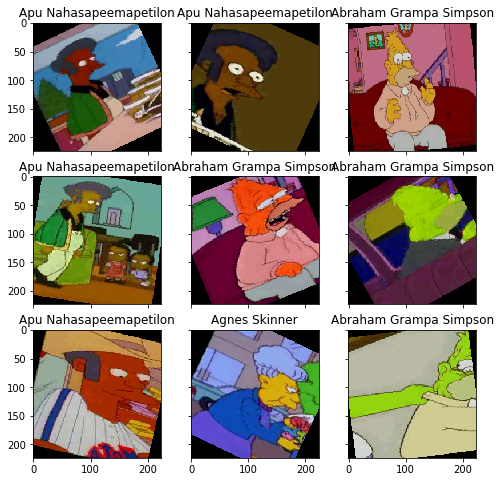

In [17]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = new_train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### Building a simple CNN

Let's try to classify the images using this very simple cnn model:

In [19]:
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [22]:
model = SimpleCnn(42) # create a model to classify objects into 42 classes

## Train

In [23]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    print(train_acc)
    return train_loss, train_acc

In [24]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [25]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(),lr=0.001)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [26]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [27]:
n_classes = len(np.unique(train_val_labels))
print("we will classify :{}".format(n_classes))

we will classify :42


In [28]:
device = torch.device('cuda')
model=model.to(device=device)

In [29]:
history = train(new_train_dataset, val_dataset, model=model, epochs=5, batch_size=64)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

0.25313714249315244
loss 2.7059759080421393


epoch:  20%|██        | 1/5 [02:26<09:44, 146.14s/it]


Epoch 001 train_loss: 2.7060     val_loss 2.2263 train_acc 0.2531 val_acc 0.3875
0.46996623988789094
loss 1.9446564298031763


epoch:  40%|████      | 2/5 [04:49<07:16, 145.41s/it]


Epoch 002 train_loss: 1.9447     val_loss 1.4999 train_acc 0.4700 val_acc 0.5971
0.6074272246639913
loss 1.4381817869414448


epoch:  60%|██████    | 3/5 [07:16<04:51, 145.92s/it]


Epoch 003 train_loss: 1.4382     val_loss 1.2121 train_acc 0.6074 val_acc 0.6716
0.6791515383145423
loss 1.1738615515839712


epoch:  80%|████████  | 4/5 [09:35<02:23, 143.74s/it]


Epoch 004 train_loss: 1.1739     val_loss 1.0659 train_acc 0.6792 val_acc 0.7125
0.7308745779985987
loss 0.9910052691958453


epoch: 100%|██████████| 5/5 [11:56<00:00, 143.26s/it]


Epoch 005 train_loss: 0.9910     val_loss 0.9157 train_acc 0.7309 val_acc 0.7608


So, we've got pretty low accuracy. However, it is not that bad considering the fact that we had a very simple model and trained it from scratch. And also the size of our dataset is rather small.

Plot the learning curves.

In [30]:
loss, acc, val_loss, val_acc = zip(*history)

In [32]:
torch.save(model,"simple_cnn_model.pth")

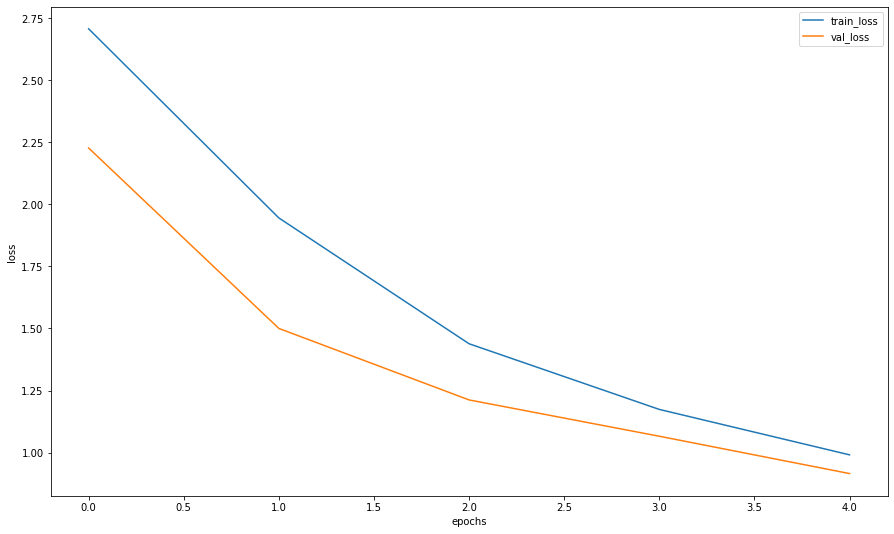

In [33]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

# Transfer learning

In computer vision tasks, if we have a dataset with less than ~1 million images, it is common to use transfer learning. The idea is that you take a model that was already trained on some dataset (usually on ImageNet), then freeze some of its first layers, depending on how much data we have in our dataset, and then only train the rest of the layers (it is called finetuning).

We are going to use resnet101 model for this task.

In [34]:
from torchvision.models import resnet101

In [35]:
model = resnet101(pretrained=True)

In [36]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 42, bias=True) # change the output size to be 42 (as number of classes)

In [37]:
# freeze most of the layers except layer4.2 and fc
params = []
for p in model.parameters():
    p.requires_grad = False
for name, m in model.named_modules():
    if name == 'layer4.2' or name == 'fc':
        for p_name, p in m.named_parameters():
            p.requires_grad = True
            params.append(p)
            print(name+"."+p_name) # print the names of layers that will be trained

layer4.2.conv1.weight
layer4.2.bn1.weight
layer4.2.bn1.bias
layer4.2.conv2.weight
layer4.2.bn2.weight
layer4.2.bn2.bias
layer4.2.conv3.weight
layer4.2.bn3.weight
layer4.2.bn3.bias
fc.weight
fc.bias


In [38]:
model=model.to(device=device)

In [41]:
history = train(new_train_dataset, val_dataset, model=model, epochs=25, batch_size=64) # increase the number of epochs up to 25

epoch:   0%|          | 0/25 [00:00<?, ?it/s]

0.7035479966876871
loss 1.1500700413630232


epoch:   4%|▍         | 1/25 [06:05<2:26:17, 365.73s/it]


Epoch 001 train_loss: 1.1501     val_loss 0.8124 train_acc 0.7035 val_acc 0.7904
0.7845085674246768
loss 0.8100916871930226


epoch:   8%|▊         | 2/25 [12:13<2:20:26, 366.36s/it]


Epoch 002 train_loss: 0.8101     val_loss 0.6343 train_acc 0.7845 val_acc 0.8347
0.8445123893241607
loss 0.5745550937880847


epoch:  12%|█▏        | 3/25 [18:26<2:15:06, 368.46s/it]


Epoch 003 train_loss: 0.5746     val_loss 0.5852 train_acc 0.8445 val_acc 0.8556
0.8677622778520925
loss 0.4886676427288962


epoch:  16%|█▌        | 4/25 [24:35<2:08:59, 368.53s/it]


Epoch 004 train_loss: 0.4887     val_loss 0.5919 train_acc 0.8678 val_acc 0.8452
0.8775081215364036
loss 0.4418893821627192


epoch:  20%|██        | 5/25 [30:43<2:02:44, 368.21s/it]


Epoch 005 train_loss: 0.4419     val_loss 0.5345 train_acc 0.8775 val_acc 0.8666
0.8935600993693866
loss 0.39308758097375623


epoch:  24%|██▍       | 6/25 [36:45<1:56:05, 366.59s/it]


Epoch 006 train_loss: 0.3931     val_loss 0.6274 train_acc 0.8936 val_acc 0.8487
0.8995477418943881
loss 0.36644327735071675


epoch:  28%|██▊       | 7/25 [42:57<1:50:25, 368.10s/it]


Epoch 007 train_loss: 0.3664     val_loss 0.4444 train_acc 0.8995 val_acc 0.8835
0.9030511497547614
loss 0.3407827762443022


epoch:  32%|███▏      | 8/25 [49:13<1:45:00, 370.60s/it]


Epoch 008 train_loss: 0.3408     val_loss 0.4685 train_acc 0.9031 val_acc 0.8829
0.9165551945983821
loss 0.2936236217121568


epoch:  36%|███▌      | 9/25 [55:26<1:38:59, 371.21s/it]


Epoch 009 train_loss: 0.2936     val_loss 0.4137 train_acc 0.9166 val_acc 0.8942
0.9211414739792343
loss 0.2826340442512801


epoch:  40%|████      | 10/25 [1:01:35<1:32:35, 370.38s/it]


Epoch 010 train_loss: 0.2826     val_loss 0.4341 train_acc 0.9211 val_acc 0.9006
0.9244537868654055
loss 0.2691816654362658


epoch:  44%|████▍     | 11/25 [1:07:43<1:26:15, 369.67s/it]


Epoch 011 train_loss: 0.2692     val_loss 0.3711 train_acc 0.9245 val_acc 0.9100
0.9309510159882796
loss 0.24582884289882875


epoch:  48%|████▊     | 12/25 [1:14:04<1:20:51, 373.21s/it]


Epoch 012 train_loss: 0.2458     val_loss 0.3887 train_acc 0.9310 val_acc 0.9047


epoch:  48%|████▊     | 12/25 [1:14:25<1:20:37, 372.13s/it]


KeyboardInterrupt: 

Let't try to use early stopping to prevent overfitting. It seems that val accuracy is not improving that much.

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

In [42]:
def predict_one_sample(model, inputs, device=DEVICE):
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [43]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

In [64]:
idxs = list(map(int, np.random.uniform(0,len(val_dataset), 100)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

In [65]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [66]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [67]:
from sklearn.metrics import f1_score
# f1 score for 100 random images from the validation set
f1_score(actual_labels, y_pred, average='micro')

0.93

Let's make a visualization to see how confident our model about its predictions.

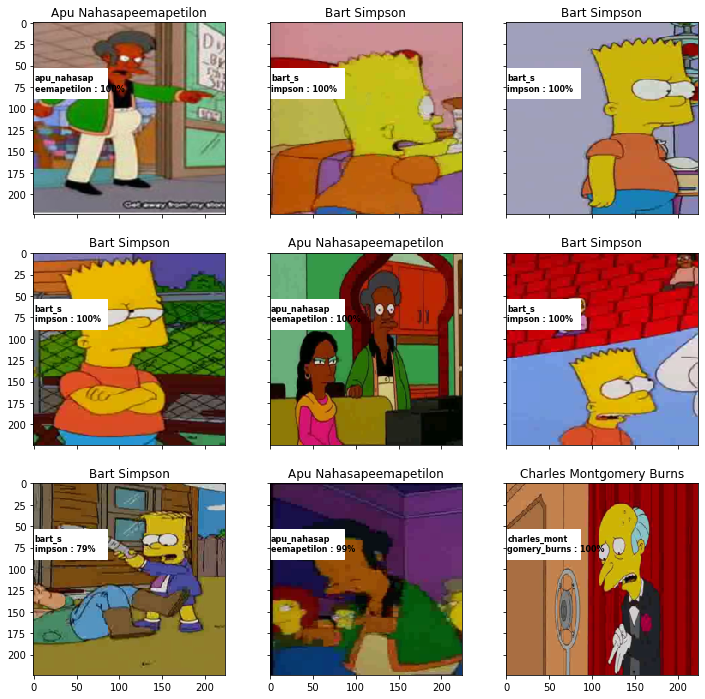

In [48]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

### Make predictions for the test set and submit to Kaggle

In [68]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [69]:
import pandas as pd
mysubmit = pd.DataFrame(columns=['Id'])
test_filenames = [path.name for path in test_dataset.files]
mysubmit['Id'] = test_filenames

In [77]:
mysubmit[f'Expected'] = preds
mysubmit.to_csv('resnet101_12epochs.csv', index=False)

After sumbitting our predictions to Kaggle we've got **the following score: 0.93092**, calculated using f1 metric

There are also several techniques that we could have used to improve the accuracy. For example:
* TTA (test time augmentation)
* Ensembling
* Tuning the hyperparameters, etc.